Wyniki Algorytmu Genetycznego:
rho = 3:
  N = 5, VM = -8.313176456585119
  N = 6, VM = -11.426760870235674
  N = 7, VM = -14.031803549847691
  N = 8, VM = -17.233079518332957
rho = 6:
  N = 5, VM = -6.576790704192002
  N = 6, VM = -6.830900642409297
  N = 7, VM = -9.049716424220481
  N = 8, VM = -9.85066821231864
rho = 10:
  N = 5, VM = -5.281932921797328
  N = 6, VM = -5.656750545718022
  N = 7, VM = -5.2126273354997945
  N = 8, VM = -7.348323114341377
rho = 14:
  N = 5, VM = -3.5568025495388427
  N = 6, VM = -3.822581849895785
  N = 7, VM = -5.788112346414793
  N = 8, VM = -5.597329065570467

Wyniki Algorytmu PSO:
rho = 3:
  N = 5, VM = -7.205062457365748
  N = 6, VM = -11.49475169976658
  N = 7, VM = -14.520391858009209
  N = 8, VM = -18.279534445196564
rho = 6:
  N = 5, VM = -5.165095296861568
  N = 6, VM = -6.736162171406039
  N = 7, VM = -9.127478844056633
  N = 8, VM = -5.6911669136581216
rho = 10:
  N = 5, VM = -3.6555119850099107
  N = 6, VM = -6.571945232323875
  N = 7, VM = 

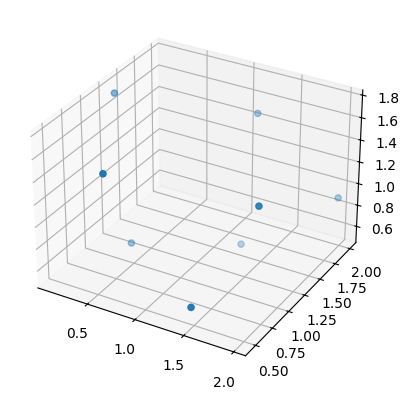

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Parametry dla Morse'a
rho_values = [3, 6, 10, 14]

# Funkcja Morse'a
def morse_potential(r, rho):
    return np.exp(rho * (1 - r)) * (np.exp(rho * (1 - r)) - 2)

# Obliczanie całkowitej energii klastra
def total_morse_energy(positions, rho):
    distances = pdist(positions)
    energy = np.sum(morse_potential(distances, rho))
    return energy

# Generowanie losowych początkowych pozycji
def generate_initial_positions(N):
    return np.random.rand(N, 3) * 2  # W przedziale [0,2]

# Algorytm Genetyczny
def genetic_algorithm(N, rho, pop_size=100, generations=500, mutation_rate=0.01):
    # Inicjalizacja populacji
    population = [generate_initial_positions(N) for _ in range(pop_size)]
    best_solution = None
    best_fitness = float('inf')

    for generation in range(generations):
        fitness = np.array([total_morse_energy(individual, rho) for individual in population])
        best_index = np.argmin(fitness)
        
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            best_solution = population[best_index]

        # Selekcja (turniej)
        selected = [population[np.random.choice(np.arange(pop_size))] for _ in range(pop_size)]
        
        # Krzyżowanie
        children = []
        for i in range(0, pop_size, 2):
            parent1, parent2 = selected[i], selected[i+1]
            crossover_point = np.random.randint(1, N*3-1)
            child1 = np.concatenate([parent1.flatten()[:crossover_point], parent2.flatten()[crossover_point:]]).reshape(N, 3)
            child2 = np.concatenate([parent2.flatten()[:crossover_point], parent1.flatten()[crossover_point:]]).reshape(N, 3)
            children.append(child1)
            children.append(child2)
        
        # Mutacja
        for child in children:
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, N*3)
                child.flatten()[idx] = np.random.rand() * 2
        
        # Aktualizacja populacji
        population = children

    return best_solution, best_fitness

# Algorytm PSO
def pso(N, rho, swarm_size=100, iterations=500, w=0.5, c1=2, c2=2):
    positions = [generate_initial_positions(N) for _ in range(swarm_size)]
    velocities = [np.random.rand(N, 3) * 0.1 for _ in range(swarm_size)]
    p_best_positions = positions[:]
    p_best_scores = [total_morse_energy(pos, rho) for pos in positions]
    g_best_position = p_best_positions[np.argmin(p_best_scores)]
    g_best_score = min(p_best_scores)

    for iteration in range(iterations):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = w * velocities[i] + c1 * r1 * (p_best_positions[i] - positions[i]) + c2 * r2 * (g_best_position - positions[i])
            positions[i] += velocities[i]

            fitness = total_morse_energy(positions[i], rho)
            if fitness < p_best_scores[i]:
                p_best_scores[i] = fitness
                p_best_positions[i] = positions[i]
                if fitness < g_best_score:
                    g_best_score = fitness
                    g_best_position = positions[i]

    return g_best_position, g_best_score

# Eksperymenty dla różnych wartości N i rho
N_values = [5, 6, 7, 8]
results_ga = {}
results_pso = {}

for rho in rho_values:
    results_ga[rho] = []
    results_pso[rho] = []
    for N in N_values:
        best_solution_ga, best_fitness_ga = genetic_algorithm(N, rho)
        best_solution_pso, best_fitness_pso = pso(N, rho)
        results_ga[rho].append((N, best_fitness_ga))
        results_pso[rho].append((N, best_fitness_pso))

# Wypisanie wyników
print("Wyniki Algorytmu Genetycznego:")
for rho, results in results_ga.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

print("\nWyniki Algorytmu PSO:")
for rho, results in results_pso.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

# Wizualizacja najlepszego klastra
best_cluster = genetic_algorithm(8, 6)[0]  # Przykład dla N=8, rho=6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(best_cluster[:, 0], best_cluster[:, 1], best_cluster[:, 2])
plt.show()


Wyniki Algorytmu Genetycznego:
rho = 3:
  N = 5, VM = -8.104602214695314
  N = 6, VM = -11.086767985316836
  N = 7, VM = -13.857038912261993
  N = 8, VM = -17.472686430836358
rho = 6:
  N = 5, VM = -6.12698742275486
  N = 6, VM = -7.58020278041647
  N = 7, VM = -10.012570353923222
  N = 8, VM = -9.674214986595189
rho = 10:
  N = 5, VM = -5.562216591222936
  N = 6, VM = -7.009015286847282
  N = 7, VM = -6.267552386202217
  N = 8, VM = -5.067769917618865
rho = 14:
  N = 5, VM = -5.4523842818527495
  N = 6, VM = -5.667691763606762
  N = 7, VM = -6.2711950486709265
  N = 8, VM = -3.9213383210113184

Wyniki Algorytmu PSO:
rho = 3:
  N = 5, VM = -9.181947651351347
  N = 6, VM = -11.244112304831827
  N = 7, VM = -15.776920435675539
  N = 8, VM = -16.916039334904415
rho = 6:
  N = 5, VM = -5.19453552188018
  N = 6, VM = -6.739225636141747
  N = 7, VM = -6.936195545233989
  N = 8, VM = -7.901300780610473
rho = 10:
  N = 5, VM = -5.434171345118902
  N = 6, VM = -6.250784579690111
  N = 7, VM = -

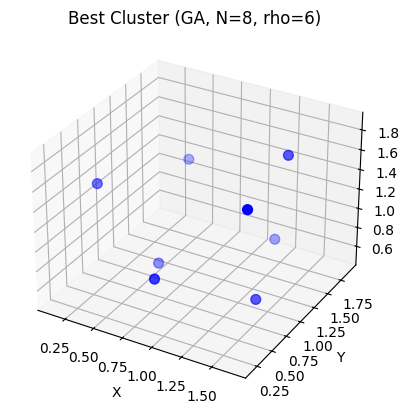

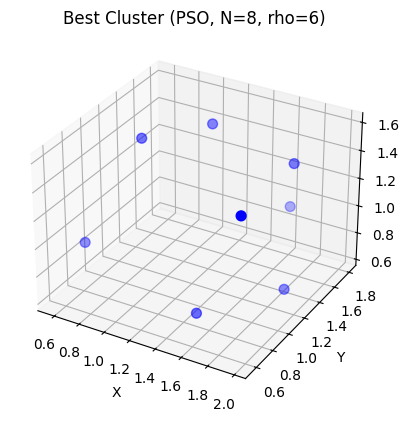

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform

# Parametry dla Morse'a
rho_values = [3, 6, 10, 14]

# Funkcja Morse'a
def morse_potential(r, rho):
    return np.exp(rho * (1 - r)) * (np.exp(rho * (1 - r)) - 2)

# Obliczanie całkowitej energii klastra
def total_morse_energy(positions, rho):
    distances = pdist(positions)
    energy = np.sum(morse_potential(distances, rho))
    return energy

# Generowanie losowych początkowych pozycji
def generate_initial_positions(N):
    return np.random.rand(N, 3) * 2  # W przedziale [0,2]

# Algorytm Genetyczny
def genetic_algorithm(N, rho, pop_size=200, generations=1000, mutation_rate=0.02):
    # Inicjalizacja populacji
    population = [generate_initial_positions(N) for _ in range(pop_size)]
    best_solution = None
    best_fitness = float('inf')

    for generation in range(generations):
        fitness = np.array([total_morse_energy(individual, rho) for individual in population])
        best_index = np.argmin(fitness)
        
        if fitness[best_index] < best_fitness:
            best_fitness = fitness[best_index]
            best_solution = population[best_index]

        # Selekcja (turniej)
        selected = [population[np.random.choice(np.arange(pop_size))] for _ in range(pop_size)]
        
        # Krzyżowanie
        children = []
        for i in range(0, pop_size, 2):
            parent1, parent2 = selected[i], selected[i+1]
            crossover_point = np.random.randint(1, N*3-1)
            child1 = np.concatenate([parent1.flatten()[:crossover_point], parent2.flatten()[crossover_point:]]).reshape(N, 3)
            child2 = np.concatenate([parent2.flatten()[:crossover_point], parent1.flatten()[crossover_point:]]).reshape(N, 3)
            children.append(child1)
            children.append(child2)
        
        # Mutacja
        for child in children:
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(0, N*3)
                child.flatten()[idx] = np.random.rand() * 2
        
        # Aktualizacja populacji
        population = children

    return best_solution, best_fitness

# Algorytm PSO
def pso(N, rho, swarm_size=200, iterations=1000, w=0.5, c1=2, c2=2):
    positions = [generate_initial_positions(N) for _ in range(swarm_size)]
    velocities = [np.random.rand(N, 3) * 0.1 for _ in range(swarm_size)]
    p_best_positions = positions[:]
    p_best_scores = [total_morse_energy(pos, rho) for pos in positions]
    g_best_position = p_best_positions[np.argmin(p_best_scores)]
    g_best_score = min(p_best_scores)

    for iteration in range(iterations):
        for i in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = w * velocities[i] + c1 * r1 * (p_best_positions[i] - positions[i]) + c2 * r2 * (g_best_position - positions[i])
            positions[i] += velocities[i]

            fitness = total_morse_energy(positions[i], rho)
            if fitness < p_best_scores[i]:
                p_best_scores[i] = fitness
                p_best_positions[i] = positions[i]
                if fitness < g_best_score:
                    g_best_score = fitness
                    g_best_position = positions[i]

    return g_best_position, g_best_score

# Eksperymenty dla różnych wartości N i rho
N_values = [5, 6, 7, 8]
results_ga = {}
results_pso = {}

for rho in rho_values:
    results_ga[rho] = []
    results_pso[rho] = []
    for N in N_values:
        best_solution_ga, best_fitness_ga = genetic_algorithm(N, rho)
        best_solution_pso, best_fitness_pso = pso(N, rho)
        results_ga[rho].append((N, best_fitness_ga))
        results_pso[rho].append((N, best_fitness_pso))

# Wypisanie wyników
print("Wyniki Algorytmu Genetycznego:")
for rho, results in results_ga.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

print("\nWyniki Algorytmu PSO:")
for rho, results in results_pso.items():
    print(f"rho = {rho}:")
    for N, fitness in results:
        print(f"  N = {N}, VM = {fitness}")

# Wizualizacja najlepszego klastra
def visualize_cluster(positions, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=50, c='b', marker='o')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Przykładowa wizualizacja najlepszego klastra dla N=8, rho=6
best_cluster_ga, _ = genetic_algorithm(8, 6)
best_cluster_pso, _ = pso(8, 6)

visualize_cluster(best_cluster_ga, "Best Cluster (GA, N=8, rho=6)")
visualize_cluster(best_cluster_pso, "Best Cluster (PSO, N=8, rho=6)")


import py3Dmol





In [36]:
def visualize_cluster_3Dmol(positions, radius=0.1, stick_radius=0.02):
    viewer = py3Dmol.view()
    viewer.setBackgroundColor('#ebf4fb')
    for pos in positions:
        viewer.addSphere({"center": {"x": pos[0], "y": pos[1], "z": pos[2]}, "radius": radius, "color": "purple"})
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            viewer.addCylinder({"start": {"x": positions[i][0], "y": positions[i][1], "z": positions[i][2]},
                                "end": {"x": positions[j][0], "y": positions[j][1], "z": positions[j][2]},
                                "radius": stick_radius, "color": "blue"})
    viewer.show()

In [37]:
# Wizualizacja najlepszego klastra dla GA za pomocą py3Dmol
visualize_cluster_3Dmol(best_cluster_ga)

# Wizualizacja najlepszego klastra dla PSO za pomocą py3Dmol
visualize_cluster_3Dmol(best_cluster_pso)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.